### Actor-Critic for Pendulum-v0

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
env = gym.make("Pendulum-v0")
s = env.reset()

In [3]:
obs_shape = env.observation_space.shape
action_shape = env.action_space.shape

In [4]:
obs_shape, action_shape

((3,), (1,))

In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.dense1 = nn.Linear(obs_shape[0], 200) 
        self.dense2 = nn.Linear(200, 1)
        self.dense3 = nn.Linear(200, 1)
        
        
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = F.relu(self.dense1(x))
        self.mu = self.dense2(x)
        self.sigma = self.dense3(x)
        
        self.mu = torch.squeeze(self.mu)
        self.sigma = F.softplus(torch.squeeze(self.sigma)) + 1e-5
        self.normal = torch.distributions.normal.Normal(self.mu, self.sigma)
        action = self.normal.sample(sample_shape=torch.Size(action_shape))
        action = torch.clamp(action, env.action_space.low[0], env.action_space.high[0])
        return action
    
    def get_entropy(self):
        return self.normal.entropy()
    
    def get_log_prob(self, action):
        return self.normal.log_prob(action)

In [6]:
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.dense1 = nn.Linear(obs_shape[0], 200)
        self.dense2 = nn.Linear(200, 1)
        
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = F.relu(self.dense1(x))
        v_s = self.dense2(x)
        
        return v_s

In [7]:
policy_estimator = PolicyNetwork().to(device)
policy_estimator([s]).shape

torch.Size([1])

In [8]:
a = policy_estimator([s])

In [9]:
policy_estimator.get_log_prob(a).size()

torch.Size([1])

In [10]:
env.action_space.sample().shape

(1,)

In [11]:
value_estimator = ValueNetwork().to(device)

In [12]:
def generate_session(tmax=1000):
    states, actions, rewards, dones, next_states = [], [], [], [], []
    s = env.reset()
    for i in range(tmax):
        action = policy_estimator([s])
        new_s, reward, done, info = env.step(action.cpu().data.numpy())
        
        if done:
            break
        
        states.append(s)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        next_states.append(new_s)
        s = new_s
        
    return states, actions, rewards, dones, next_states

In [13]:
def compute_critic_loss(optimizer, states, rewards, next_states, gamma):
    states = torch.tensor(states, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states.astype('float'), dtype=torch.float32).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_v_s = value_estimator(next_states)
    td_target = rewards + gamma*next_v_s
    td_error = (td_target.detach() - value_estimator(states))**2
    loss = torch.mean(td_error)
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.cpu().data.numpy()

In [14]:
def compute_actor_loss(optimizer, states, actions, rewards, next_states, gamma):
    H = policy_estimator.get_entropy()
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.float32).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states.astype('float'), dtype=torch.float32)
    td_target = rewards + gamma*value_estimator(next_states)
    td_error = td_target - value_estimator(states)
    loss = -0.2*H - policy_estimator.get_log_prob(actions)*td_error.detach()
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.cpu().data.numpy(), H.cpu().data.numpy()

In [21]:
def train(gamma=0.9, episodes=1000, tmax=1000):
    opt_actor = torch.optim.Adam(policy_estimator.parameters(), lr=1e-5)
    opt_critic = torch.optim.Adam(value_estimator.parameters(), lr=1e-4)
    rewards = []
    critic_loss = []
    actor_loss = []
    entropy_loss = []
    for i_episode in range(episodes):
        state = env.reset()
        episode_rewards = []
        
        for t in range(tmax):
            
            action = policy_estimator(state)
            next_state, reward, done, _ = env.step(action)
            
            episode_rewards.append(reward)
            
            critic = compute_critic_loss(opt_critic, state, reward, next_state, gamma)
            actor, entropy = compute_actor_loss(opt_actor, state, action, reward, next_state, gamma)
            
            if t % 500 == 0:
                critic_loss.append(critic)
                actor_loss.append(actor)
                entropy_loss.append(entropy)
            
            if done:
                break
            
            state = next_state
        
        rewards.append(np.mean(np.array(episode_rewards)))
        if i_episode % 10 == 0:
            clear_output(True)
            print("episode: {}, reward: {}".format(i_episode + 1, rewards[-1]))
            plt.figure(figsize=(20, 6))
            plt.subplot(221)
            plt.plot(critic_loss)
            plt.title("Critic loss")
            plt.subplot(222)
            plt.plot(actor_loss)
            plt.title("Actor loss")
            plt.subplot(223)
            plt.plot(entropy_loss)
            plt.title("Entropy")
            plt.subplot(224)
            plt.plot(rewards)
            plt.title("Rewards")
            plt.show()

episode: 991, reward: -7.476535797119141


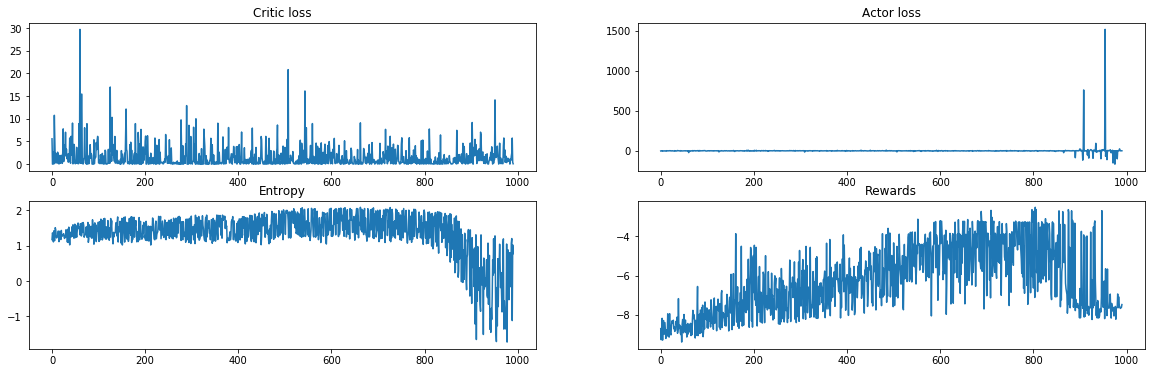

CPU times: user 53min 11s, sys: 1min 14s, total: 54min 25s
Wall time: 22min 22s


In [22]:
%%time
train()

In [17]:
state = env.reset()
for t in range(100000):
    action = policy_estimator(state).to('cpu')
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    env.render()
    if done:
        break
        
env.close()

In [18]:
policy_estimator.normal.mean

tensor(0.0630, grad_fn=<SqueezeBackward0>)

In [19]:
policy_estimator.normal.scale

tensor(0.8950, grad_fn=<AddBackward0>)